## Stock Price Prediction using Support Vector Regression and XGBoost with Stacking ensemble and Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from xgboost import XGBRegressor
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure Yahoo Finance data source
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


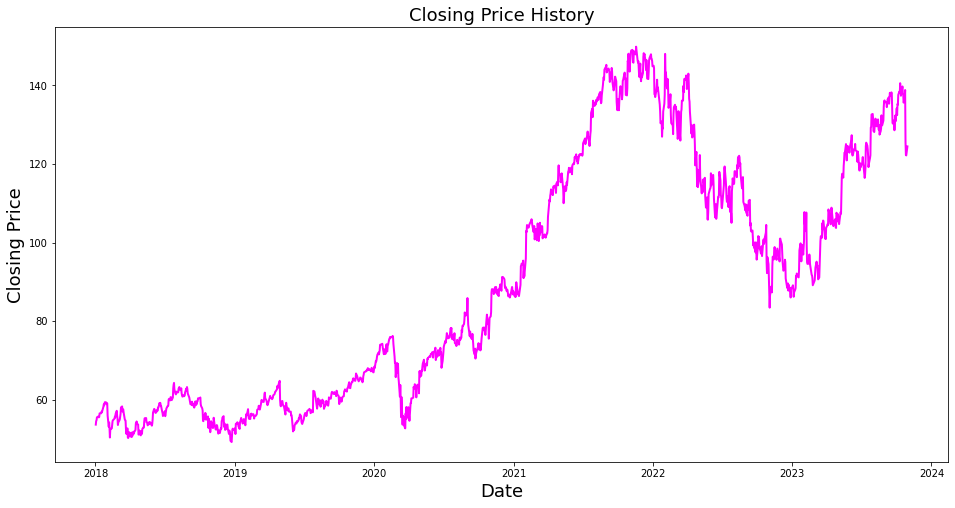

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='magenta')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

# Drop n/a values
df1.dropna(inplace=True)

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))


# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [7]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [8]:
# Build SVR model without hyperparameter tuning
svr = SVR()
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)

# Build XGB model without hyperparameter tuning
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

In [9]:
# Create a stacked model with SVR and XGB
stacked_pred = np.column_stack((pred_svr, pred_xgb))

# Train a final regressor based on the stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

# Predict on the test data
final_pred = final_regressor.predict(stacked_pred)

In [10]:
# Inverse transform the predictions and the actual values
pred_svr_inv = target_scaler.inverse_transform(pred_svr.reshape(-1,1))
pred_xgb_inv = target_scaler.inverse_transform(pred_xgb.reshape(-1,1))
pred_stack_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

In [11]:
# Calculate the Evaluation Metrics for SVR
svr_mse = mean_squared_error(y_test_inv, pred_svr_inv)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test_inv, pred_svr_inv)
svr_r2 = r2_score(y_test_inv, pred_svr_inv)

print("SVR Evaluation Metrics")
print('-----------------------')
print("MSE: {:.4f}".format(svr_mse))
print("RMSE: {:.4f}".format(svr_rmse))
print("MAE: {:.4f}".format(svr_mae))
print("R2: {:.4f}".format(svr_r2))

SVR Evaluation Metrics
-----------------------
MSE: 4.5108
RMSE: 2.1239
MAE: 1.7096
R2: 0.9827


In [12]:
# Calculate the Evaluation Metrics for XGB
xgb_mse = mean_squared_error(y_test_inv, pred_xgb_inv)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test_inv, pred_xgb_inv)
xgb_r2 = r2_score(y_test_inv, pred_xgb_inv)

print("XGB Evaluation Metrics")
print('-----------------------')
print("MSE: {:.4f}".format(xgb_mse))
print("RMSE: {:.4f}".format(xgb_rmse))
print("MAE: {:.4f}".format(xgb_mae))
print("R2: {:.4f}".format(xgb_r2))

XGB Evaluation Metrics
-----------------------
MSE: 1.8261
RMSE: 1.3513
MAE: 0.9734
R2: 0.9930


In [13]:
# Calculate the Evaluation Metrics for the Stacked Model
stack_mse = mean_squared_error(y_test_inv, pred_stack_inv)
stack_rmse = np.sqrt(stack_mse)
stack_mae = mean_absolute_error(y_test_inv, pred_stack_inv)
stack_r2 = r2_score(y_test_inv, pred_stack_inv)

print("SVR-XGBoost Stacked Model Evaluation Metrics")
print('--------------------------------------------')
print("MSE: {:.4f}".format(stack_mse))
print("RMSE: {:.4f}".format(stack_rmse))
print("MAE: {:.4f}".format(stack_mae))
print("R2: {:.4f}".format(stack_r2))

SVR-XGBoost Stacked Model Evaluation Metrics
--------------------------------------------
MSE: 1.5035
RMSE: 1.2262
MAE: 0.9202
R2: 0.9942


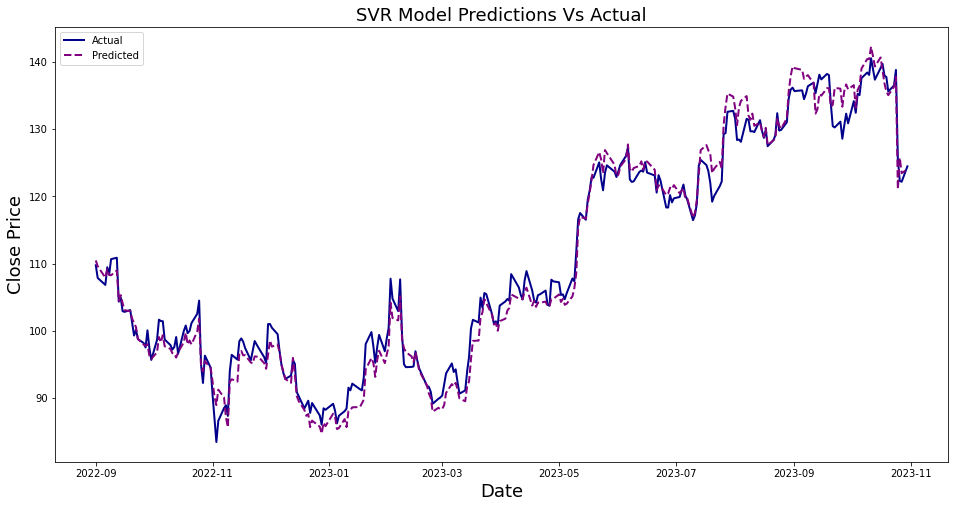

In [14]:
# Plot the actual vs predicted prices for SVR
plt.figure(figsize=(16,8))
plt.title('SVR Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_svr_inv, linewidth=2, color='purple', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

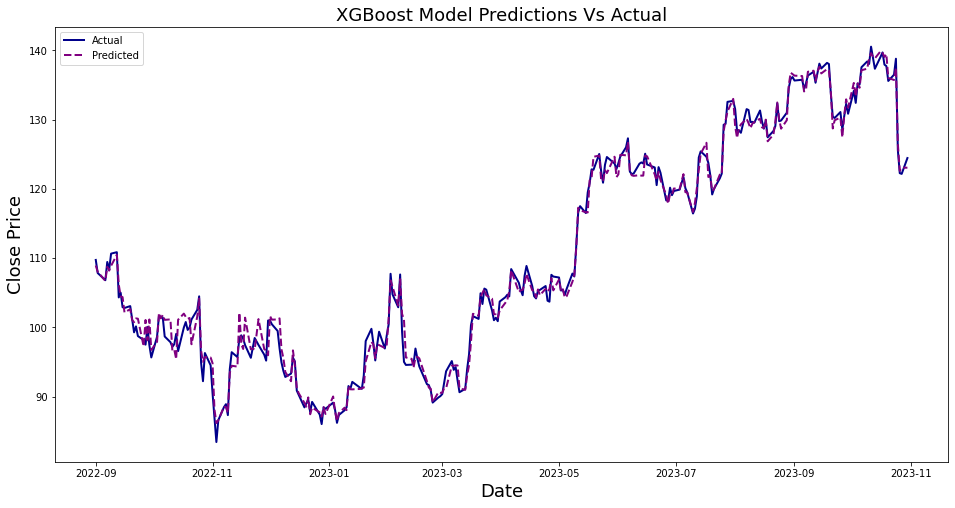

In [15]:
# Plot the actual vs predicted prices for XGB
plt.figure(figsize=(16,8))
plt.title('XGBoost Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_xgb_inv, linewidth=2, color='purple', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

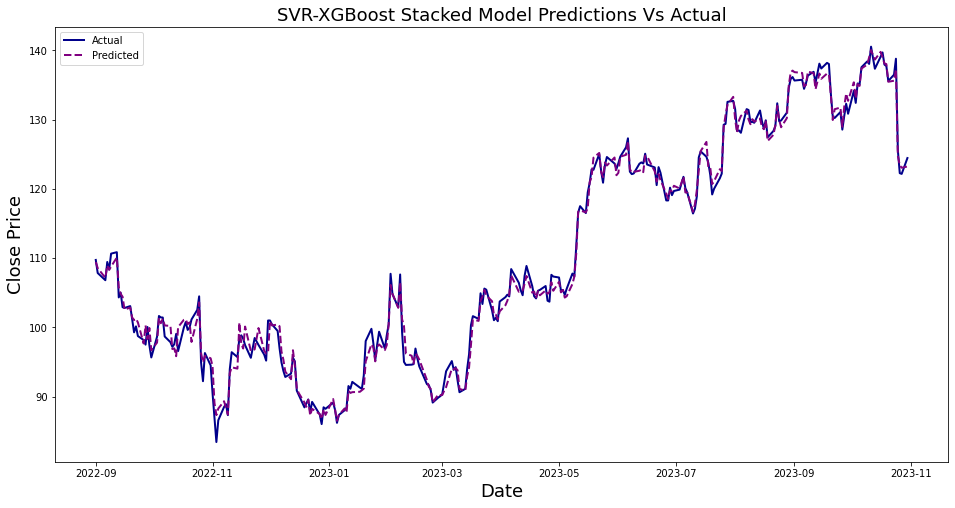

In [16]:
# Plot the actual vs predicted prices for the Stacked Model
plt.figure(figsize=(16,8))
plt.title('SVR-XGBoost Stacked Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_stack_inv, linewidth=2, color='purple', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [17]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'SVR': pred_svr_inv.flatten(), 'XGBoost': pred_xgb_inv.flatten(), 'SVR-XGBoost': pred_stack_inv.flatten()})
df_pred

,Date,Actual,SVR,XGBoost,SVR-XGBoost
0,2022-09-01,109.739998,110.458194,108.933716,109.444863
1,2022-09-02,107.849998,109.598923,108.027969,108.564009
2,2022-09-06,106.809998,107.886773,106.718987,107.155532
3,2022-09-07,109.449997,109.148575,108.748367,108.938055
4,2022-09-08,108.379997,108.290732,108.196457,108.305037
...,...,...,...,...,...
287,2023-10-24,138.809998,137.799724,137.510605,137.302962
288,2023-10-25,125.610001,121.059500,126.510628,124.789384
289,2023-10-26,122.279999,125.741213,122.611649,123.411360
290,2023-10-27,122.169998,123.438522,123.061218,123.062507


In [18]:
# Take the last day price as the base price
last_features = X_scaled[-1:]

# Predict using the svr model
predicted_prices_svr = []

last_features_svr = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_svr = svr.predict(last_features_svr)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_svr = predicted_price_svr.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_svr = target_scaler.inverse_transform(predicted_price_reshaped_svr)[0][0]
    predicted_prices_svr.append(inverse_transformed_price_svr)

    # Computing new features based on the predicted price
    new_features_svr = np.array([
        last_features_svr[0, 1], 
        last_features_svr[0, 2], 
        predicted_price_reshaped_svr[0, 0], 
        (predicted_price_reshaped_svr[0, 0] - last_features_svr[0, 3]) / last_features_svr[0, 3],
        np.mean(np.append(last_features_svr[0, 4:6], predicted_price_reshaped_svr[0, 0])),
        np.mean(np.append(last_features_svr[0, 5:], predicted_price_reshaped_svr[0, 0])),
        np.std(np.append(last_features_svr[0, 6:], predicted_price_reshaped_svr[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_svr = new_features_svr

print("\nPredicted Closing Prices for the Next 2 Days (SVR Model):")
for i, price in enumerate(predicted_prices_svr):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (SVR Model):
Day 1:124.038
Day 2:118.282


In [19]:
last_features = X_scaled[-1:]

# Predict using the XGB model
predicted_prices_xgb = []

last_features_xgb = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_xgb = xgb.predict(last_features_xgb)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_xgb = predicted_price_xgb.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_xgb = target_scaler.inverse_transform(predicted_price_reshaped_xgb)[0][0]
    predicted_prices_xgb.append(inverse_transformed_price_xgb)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_xgb = np.array([
        last_features_xgb[0, 1], 
        last_features_xgb[0, 2], 
        predicted_price_reshaped_xgb[0, 0], 
        (predicted_price_reshaped_xgb[0, 0] - last_features_xgb[0, 3]) / last_features_xgb[0, 3],
        np.mean(np.append(last_features_xgb[0, 4:6], predicted_price_reshaped_xgb[0, 0])),
        np.mean(np.append(last_features_xgb[0, 5:], predicted_price_reshaped_xgb[0, 0])),
        np.std(np.append(last_features_xgb[0, 6:], predicted_price_reshaped_xgb[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_xgb = new_features_xgb

print("\nPredicted Closing Prices for the Next 2 Days (XGB Model):")
for i, price in enumerate(predicted_prices_xgb):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (XGB Model):
Day 1:123.066
Day 2:119.455


In [20]:
last_features = X_scaled[-1:]

# Predict using the Stacked model SVR-XGB
predicted_prices_stacked = []

last_features_stacked = last_features.copy()

for _ in range(2):
    
    # Predict using SVR & XGBoost models
    svr_pred_for_stacking = svr.predict(last_features_stacked)
    xgb_pred_for_stacking = xgb.predict(last_features_stacked)

    # Stacking LSTM and xgb predictions
    stacked_predictions = np.column_stack((svr_pred_for_stacking, xgb_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # Computing new features based on the predicted price
    new_features_stacked = np.array([
        last_features_stacked[0, 1], 
        last_features_stacked[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features_stacked[0, 3]) / last_features_stacked[0, 3],
        np.mean(np.append(last_features_stacked[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features_stacked[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features_stacked[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_stacked = new_features_stacked

print("Predicted Closing Prices for the Next 2 Days (SVR-XGBoost Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (SVR-XGBoost Stacked Model):
Day 1:123.239
Day 2:118.906


In [21]:
# SVR Model with Hyperparameter Tuning
# Define the paramaters for the SVR model

parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1], 'epsilon': [0.1, 0.2, 0.5, 1]}
svr = SVR()
grid = GridSearchCV(svr, parameters, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_svr = grid.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters found: ", grid_svr.best_params_)
print("Best Score found: ", grid_svr.best_score_)
print("Best Estimator found: ", grid_svr.best_estimator_)
print("Best Index found: ", grid_svr.best_index_)
print("Scorer function used: ", grid_svr.scorer_)

# Using best estimator for svr model from the grid search
best_svr_model = grid_svr.best_estimator_

# Predict the values using the best estimator
pred_best_svr = best_svr_model.predict(X_test)

# Inverse transform the predictions
pred_best_svr_inv = target_scaler.inverse_transform(pred_best_svr.reshape(-1,1))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best Parameters found:  {'C': 1, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Score found:  -0.002160969531255808
Best Estimator found:  SVR(C=1, gamma=1)
Best Index found:  19
Scorer function used:  make_scorer(mean_squared_error, greater_is_better=False)


In [22]:
# Calculate the evaluation metrics for SVR model with Hyperparameter tuning
svr_tuned_mse = mean_squared_error(y_test_inv, pred_best_svr_inv)
svr_tuned_rmse = np.sqrt(svr_tuned_mse)
svr_tuned_mae = mean_absolute_error(y_test_inv, pred_best_svr_inv)
svr_tuned_r2 = r2_score(y_test_inv, pred_best_svr_inv)

print("Tuned SVR Model Evaluation Metrics")
print("===================================")
print("MSE: {:.4f}".format(svr_tuned_mse))
print("RMSE: {:.4f}".format(svr_tuned_rmse))
print("MAE: {:.4f}".format(svr_tuned_mae))
print("R2: {:.4f}".format(svr_tuned_r2))

Tuned SVR Model Evaluation Metrics
MSE: 7.3099
RMSE: 2.7037
MAE: 2.2592
R2: 0.9720


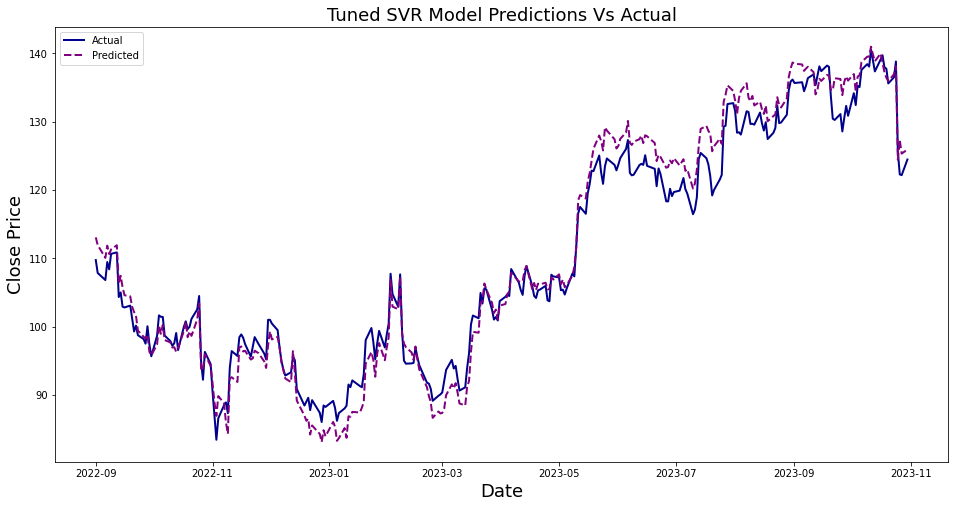

In [23]:
# Plot the actual vs predicted prices for SVR with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned SVR Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_svr_inv, linewidth=2, color='purple', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [24]:
# XGBRegressor model with hyperparameter tuning
# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 10, 15, 20],
                'learning_rate': [0.01, 0.05, 0.1],
                'colsample_bytree': [0.3, 0.5, 0.7],
                'gamma': [0, 0.1, 0.2]}

# Grid search on XGBRegressor
grid = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for XGBRegressor from the grid search
best_xgb_model = grid_result.best_estimator_

# Predicting the test data
pred_best_xgb = best_xgb_model.predict(X_test)

# Inverse transform the predictions
pred_best_xgb_inv = target_scaler.inverse_transform(pred_best_xgb.reshape(-1,1))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best score:  0.9729029346752484
Best estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [25]:
# Calculate the evaluation metrics for XGBoost Regressor
xgb_tuned_mse = mean_squared_error(y_test_inv, pred_best_xgb_inv)
xgb_tuned_rmse = np.sqrt(xgb_tuned_mse)
xgb_tuned_r2 = r2_score(y_test_inv, pred_best_xgb_inv)
xgb_tuned_mae = mean_absolute_error(y_test_inv, pred_best_xgb_inv)

print('Tuned XGBoost Regressor Evaluation Metrics')
print('===========================================')
print('MSE: {:.4f}'.format(xgb_tuned_mse))
print('RMSE: {:.4f}'.format(xgb_tuned_rmse))
print('MAE: {:.4f}'.format(xgb_tuned_mae))
print('R2 Score: {:.4f}'.format(xgb_tuned_r2))

Tuned XGBoost Regressor Evaluation Metrics
MSE: 1.0999
RMSE: 1.0487
MAE: 0.7875
R2 Score: 0.9958


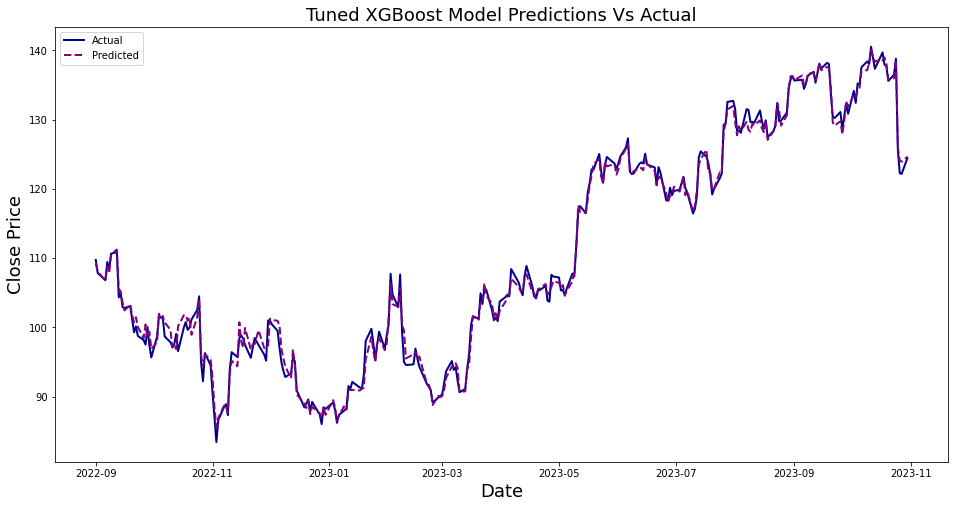

In [26]:
# Plot the actual vs predicted prices for XGBRegressor with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned XGBoost Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_xgb_inv, linewidth=2, color='purple', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [27]:
# Create a stacked model using np.column_stack
stacked_tune_pred = np.column_stack((pred_best_svr, pred_best_xgb))

# Train a final regressor based on the stacked predictions
final_tuned_regressor = LinearRegression().fit(stacked_tune_pred, y_test)

# Predict on the test data
final_tuned_pred = final_tuned_regressor.predict(stacked_tune_pred)

# Inverse transform the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [28]:
# Calculate the evaluation metrics for the stacked ensemble model with hyperparameter tuning
final_tuned_mse = mean_squared_error(y_test_inv, final_tuned_pred_inv)
final_tuned_rmse = np.sqrt(final_tuned_mse)
final_tuned_mae = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
final_tuned_r2 = r2_score(y_test_inv, final_tuned_pred_inv)

print('Tuned SVR-XGBoost Stacked Model Evaluation Metrics')
print("==================================================")
print('MSE: {:.4f}'.format(final_tuned_mse))
print('RMSE: {:.4f}'.format(final_tuned_rmse))
print('MAE: {:.4f}'.format(final_tuned_mae))
print('R2: {:.4f}'.format(final_tuned_r2))

Tuned SVR-XGBoost Stacked Model Evaluation Metrics
MSE: 1.0153
RMSE: 1.0076
MAE: 0.7741
R2: 0.9961


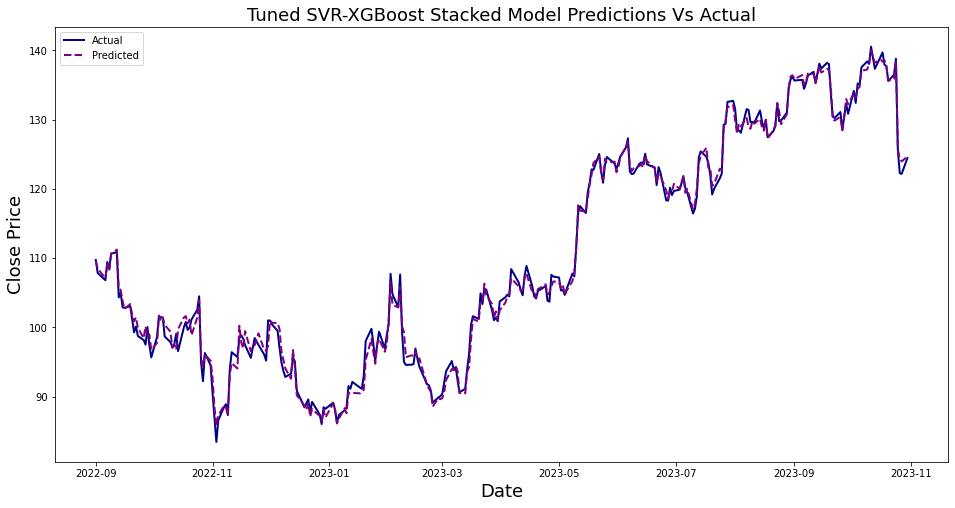

In [29]:
# Plot the actual vs predicted prices for the Stacked Model with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned SVR-XGBoost Stacked Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], final_tuned_pred_inv, linewidth=2, color='purple', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [30]:
# Build a dataframe with actual and predicted prices
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'Tuned SVR': pred_best_svr_inv.flatten(), 'Tuned XGBoost': pred_best_xgb_inv.flatten(), 'Tuned SVR-XGBoost': final_tuned_pred_inv.flatten()})
df_pred_1.tail(20)

,Date,Actual,Tuned SVR,Tuned XGBoost,Tuned SVR-XGBoost
272,2023-10-03,132.429993,134.404998,133.168884,133.148397
273,2023-10-04,135.240005,136.595297,134.396576,134.488569
274,2023-10-05,135.070007,136.788777,134.616638,134.704439
275,2023-10-06,137.580002,138.721514,137.026596,137.045945
276,2023-10-09,138.419998,139.511125,137.158478,137.257648
277,2023-10-10,138.059998,139.528211,138.159683,138.134362
278,2023-10-11,140.550003,140.977515,140.062332,139.973614
279,2023-10-12,138.970001,139.817446,139.158752,139.042481
280,2023-10-13,137.360001,138.847797,138.368515,138.233641
281,2023-10-16,139.100006,139.980253,138.692535,138.655105


In [31]:
last_features = X_scaled[-1:]

# Predict using the best SVR model
predicted_prices_best_svr = []

last_features_best_svr = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_best_svr = best_svr_model.predict(last_features_best_svr)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_svr = predicted_price_best_svr.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_svr = target_scaler.inverse_transform(predicted_price_reshaped_svr)[0][0]
    predicted_prices_best_svr.append(inverse_transformed_price_svr)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_svr = np.array([
        last_features_best_svr[0, 1], 
        last_features_best_svr[0, 2], 
        predicted_price_reshaped_svr[0, 0], 
        (predicted_price_reshaped_svr[0, 0] - last_features_best_svr[0, 3]) / last_features_best_svr[0, 3],
        np.mean(np.append(last_features_best_svr[0, 4:6], predicted_price_reshaped_svr[0, 0])),
        np.mean(np.append(last_features_best_svr[0, 5:], predicted_price_reshaped_svr[0, 0])),
        np.std(np.append(last_features_best_svr[0, 6:], predicted_price_reshaped_svr[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_svr = new_features_svr

print("\nPredicted Closing Prices for the Next 2 Days (Best SVR Model):")
for i, price in enumerate(predicted_prices_best_svr):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (Best SVR Model):
Day 1:125.925
Day 2:123.521


In [32]:
last_features = X_scaled[-1:]

# Predict using the best XGBoost model
predicted_prices_best_xgb = []

last_features_best_xgb = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_best_xgb = best_xgb_model.predict(last_features_best_xgb)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_best_xgb = predicted_price_best_xgb.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_best_xgb = target_scaler.inverse_transform(predicted_price_reshaped_best_xgb)[0][0]
    predicted_prices_best_xgb.append(inverse_transformed_price_best_xgb)

    # Computing new features based on the predicted price
    new_features_best_xgb = np.array([
        last_features_best_xgb[0, 1], 
        last_features_best_xgb[0, 2], 
        predicted_price_reshaped_best_xgb[0, 0], 
        (predicted_price_reshaped_best_xgb[0, 0] - last_features_best_xgb[0, 3]) / last_features_best_xgb[0, 3],
        np.mean(np.append(last_features_best_xgb[0, 4:6], predicted_price_reshaped_best_xgb[0, 0])),
        np.mean(np.append(last_features_best_xgb[0, 5:], predicted_price_reshaped_best_xgb[0, 0])),
        np.std(np.append(last_features_best_xgb[0, 6:], predicted_price_reshaped_best_xgb[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_xgb = new_features_best_xgb

print("Predicted Closing Prices for the Next 2 Days (Best XGBoost Model):")
for i, price in enumerate(predicted_prices_best_xgb):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (Best XGBoost Model):
Day 1:124.667
Day 2:123.846


In [33]:
last_features = X_scaled[-1:]

# Predict using the best Stacked model
predicted_prices_best_stacked = []

last_features_best_stacked = last_features.copy()

for _ in range(2):
    
    # Predict using SVR & XGBoost models
    svr_pred_for_stacking = best_svr_model.predict(last_features_best_stacked)
    xgb_pred_for_stacking = best_xgb_model.predict(last_features_best_stacked)

    # Stacking SVR and XGBoost predictions
    stacked_predictions = np.column_stack((svr_pred_for_stacking, xgb_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_tuned_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_best_stacked = predicted_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_best_stacked = target_scaler.inverse_transform(predicted_price_reshaped_best_stacked)[0][0]
    predicted_prices_best_stacked.append(inverse_transformed_price_best_stacked)

    # Computing new features based on the predicted price
    new_features_best_stacked = np.array([
        last_features_best_stacked[0, 1], 
        last_features_best_stacked[0, 2], 
        predicted_price_reshaped_best_stacked[0, 0], 
        (predicted_price_reshaped_best_stacked[0, 0] - last_features_best_stacked[0, 3]) / last_features_best_stacked[0, 3],
        np.mean(np.append(last_features_best_stacked[0, 4:6], predicted_price_reshaped_best_stacked[0, 0])),
        np.mean(np.append(last_features_best_stacked[0, 5:], predicted_price_reshaped_best_stacked[0, 0])),
        np.std(np.append(last_features_best_stacked[0, 6:], predicted_price_reshaped_best_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_stacked = new_features_best_stacked

print("Predicted Closing Prices for the Next 2 Days (Best Stacked SVR-XGBoost Model):")
for i, price in enumerate(predicted_prices_best_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (Best Stacked SVR-XGBoost Model):
Day 1:124.685
Day 2:123.592
